In [99]:
pip install keras-tuner

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Shape of train images: (60000, 28, 28)
Shape of test images: (60000,)


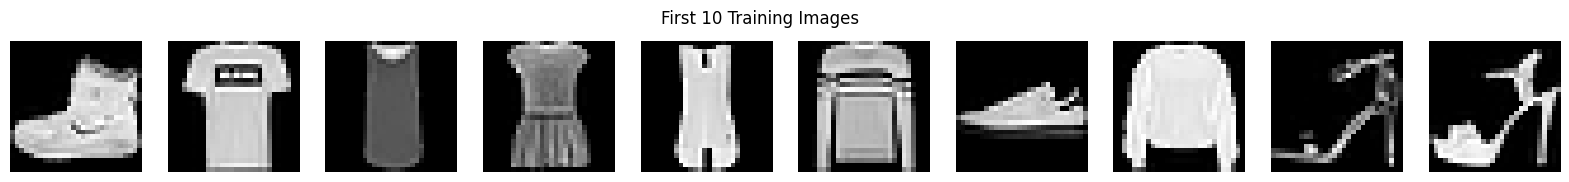

In [101]:
print(f"Shape of train images: {train_images.shape}")
print(f"Shape of test images: {train_labels.shape}")

num_images = 10
fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
for i in range(num_images):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].axis('off')
plt.suptitle('First 10 Training Images')
plt.show()

In [102]:
# Filter only the classes 4 (Coat) and 5 (Sandal)
coat_train = np.where(train_labels == 4)[0]
sandal_train = np.where(train_labels == 5)[0]

coat_train_images = train_images[coat_train]
sandal_train_images = train_images[sandal_train]

coat_train_labels = train_labels[coat_train]
sandal_train_labels = train_labels[sandal_train]

# Combine the filtered images
filtered_train_images = np.concatenate((coat_train_images, sandal_train_images), axis=0)
filtered_test_images = np.concatenate((coat_train_labels, sandal_train_labels), axis=0)

# Print the shapes of the filtered datasets
print(f"Shape of filtered train images: {filtered_train_images.shape}")
print(f"Shape of filtered test images: {filtered_test_images.shape}")

Shape of filtered train images: (12000, 28, 28)
Shape of filtered test images: (12000,)


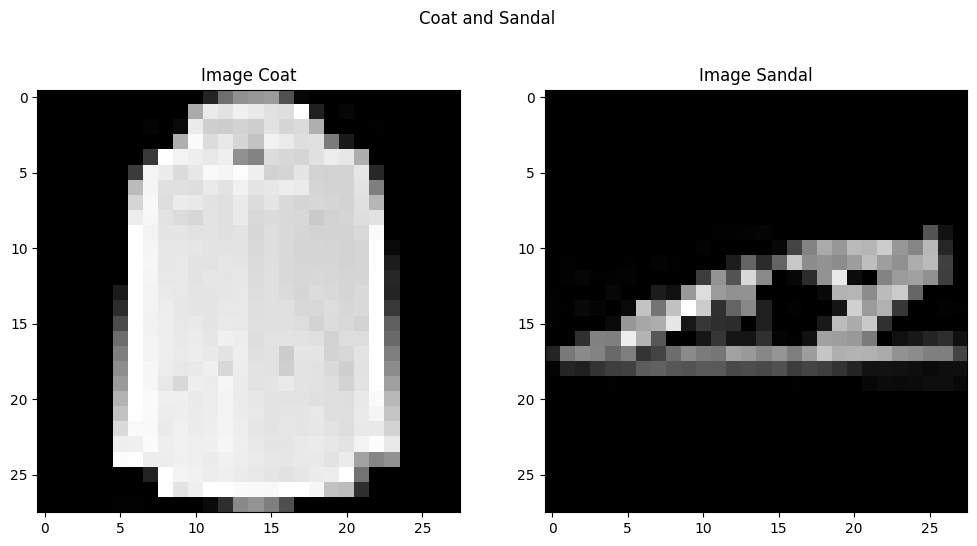

In [103]:
fig,axes = plt.subplots(1,2, figsize = (12,6))
axes[0].imshow(filtered_train_images[10], cmap='gray')
axes[0].set_title('Image Coat')

axes[1].imshow(filtered_train_images[6015], cmap='gray')
axes[1].set_title('Image Sandal')
plt.suptitle('Coat and Sandal')
plt.show()

In [104]:
filtered_train_images = filtered_train_images.astype(float) * (1.0/255)
filtered_train_images

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [105]:
x_train, x_temp, y_train, y_temp = train_test_split(filtered_train_images, filtered_test_images, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
# Print the shapes of the datasets
print(f"Shape of train images: {x_train.shape},{y_train.shape}")
print(f"Shape of validation images: {x_val.shape},{y_val.shape}")
print(f"Shape of test images: {x_test.shape},{y_test.shape}")

Shape of train images: (9600, 28, 28),(9600,)
Shape of validation images: (1200, 28, 28),(1200,)
Shape of test images: (1200, 28, 28),(1200,)


In [106]:
def example(data, label, num_images=3):
  plt.figure(figsize=(10, 5))
  for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(data[i], cmap='gray')
    plt.title(f"Label: {label[i]}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

Example Images of Coat


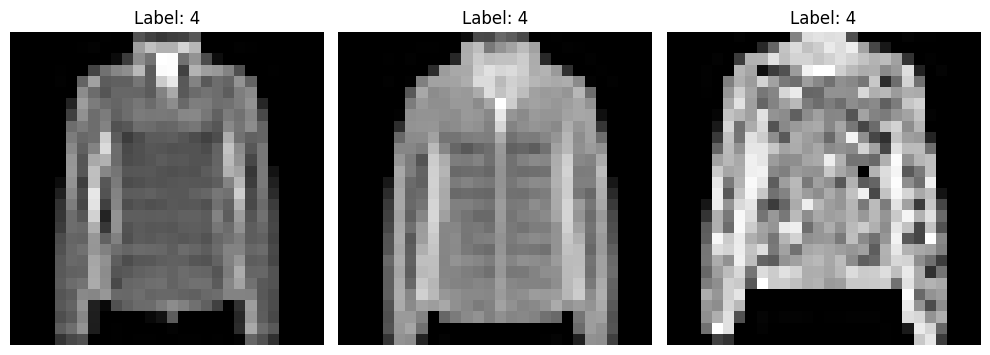

Example Images of Sandal


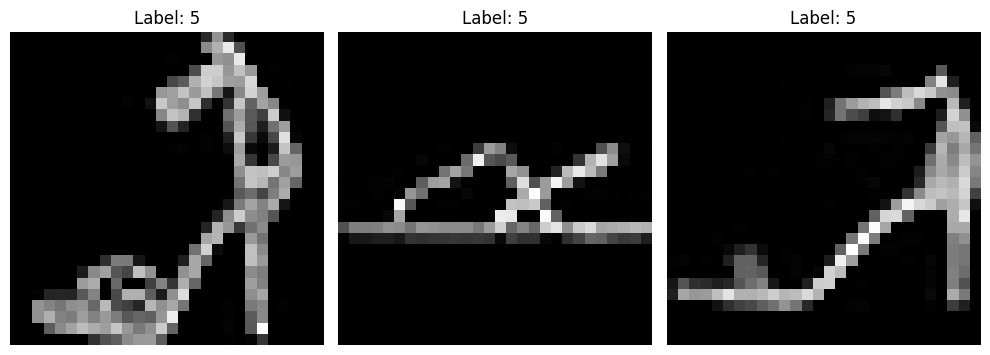

In [107]:
print("Example Images of Coat")
example(x_train[y_train == 4], y_train[y_train == 4])
print("Example Images of Sandal")
example(x_train[y_train == 5], y_train[y_train == 5])

Baseline Model

In [108]:
def build_baseline_autoencoder():
    # Baseline Encoder
    input_encoder = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_encoder)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    latent_space = layers.Dense(128, activation='relu', name='latent_space')(x)
    encoder_model = models.Model(input_encoder, latent_space, name='encoder_model')
    encoder_model.summary()

    # Baseline Decoder
    input_decoder = layers.Input(shape=(128,))
    x = layers.Dense(6272, activation='relu')(input_decoder)
    x = layers.Reshape((14, 14, 32))(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    output_decoder = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoder_model = models.Model(input_decoder, output_decoder, name='decoder_model')
    decoder_model.summary()

    # Baseline Autoencoder
    autoencoder_input = input_encoder
    encoded_output = encoder_model(autoencoder_input)
    decoded_output = decoder_model(encoded_output)
    autoencoder_model = models.Model(autoencoder_input, decoded_output, name='autoencoder_model')
    autoencoder_model.summary()

    # Compile the model
    autoencoder_model.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder_model

Modified Model

In [109]:
def build_modified_autoencoder():
    # Modified Encoder
    input_encoder = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_encoder)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    latent_space = layers.Dense(256, activation='relu', name='latent_space')(x) # Encoder outputs 256 dim vector
    encoder_model = models.Model(input_encoder, latent_space, name='encoder_model')
    encoder_model.summary()

    # Modified Decoder
    input_decoder = layers.Input(shape=(256,)) # Change decoder input to 256
    # Change the input dimension of the first Dense layer to 256
    x = layers.Dense(256, activation='relu')(input_decoder)
    x = layers.Dense(7 * 7 * 128, activation='relu')(x)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    output_decoder = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoder_model = models.Model(input_decoder, output_decoder, name='decoder_model')
    decoder_model.summary()

    # Modified Autoencoder
    autoencoder_input = input_encoder
    encoded_output = encoder_model(autoencoder_input)
    decoded_output = decoder_model(encoded_output)
    autoencoder_model = models.Model(autoencoder_input, decoded_output, name='autoencoder_model')
    autoencoder_model.summary()

    # Compile the model
    autoencoder_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
    return autoencoder_model

In [110]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [111]:
# Train Baseline Autoencoder
baseline_autoencoder = build_baseline_autoencoder()
baseline_autoencoder.fit(x_train, x_train,
                         epochs=50,
                         batch_size=256,
                         validation_data=(x_val, x_val))

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 6272)              0         
                                                                 
 latent_space (Dense)        (None, 128)               802944    
                                                                 
Total params: 803264 (3.06 MB)
Trainable params: 803264 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [112]:
# Train Modified Autoencoder
modified_autoencoder = build_modified_autoencoder()
modified_autoencoder.fit(x_train, x_train,
                         epochs=100,
                         batch_size=256,
                         validation_data=(x_val, x_val))

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 256)       

In [113]:
# Evaluasi model pada train set
baseline_train_loss = baseline_autoencoder.evaluate(x_train, x_train)
modified_train_loss = modified_autoencoder.evaluate(x_train, x_train)
print(f"Baseline Train loss: {baseline_train_loss}")
print(f"Modified Trainn loss: {modified_train_loss}")

300/300 [==============================] - 1s 4ms/step - loss: 0.2330
Baseline Train loss: 0.23766906559467316
Modified Trainn loss: 0.23304466903209686


In [114]:
# Evaluasi model pada test set
baseline_test_loss = baseline_autoencoder.evaluate(x_test, x_test)
modified_test_loss = modified_autoencoder.evaluate(x_test, x_test)
print(f"Baseline Test loss: {baseline_test_loss}")
print(f"Modified Test loss: {modified_test_loss}")

38/38 [==============================] - 0s 4ms/step - loss: 0.2410
Baseline Test loss: 0.24059425294399261
Modified Test loss: 0.24098938703536987


Tuning Hyperparamter

In [115]:
def autoencoder_model(hp):
  # Hyperparameters
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    dropout_rate = hp.Choice('dropout_rate', [0.1, 0.2, 0.3])

    # Encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    encoder_output = layers.Dense(128, activation='relu')(x)

    encoder = models.Model(encoder_input, encoder_output, name='encoder')

    # Decoder
    decoder_input = layers.Input(shape=(128,))
    x = layers.Dense(256, activation='relu')(decoder_input)
    x = layers.Dense(7 * 7 * 128, activation='relu')(x)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    decoder_output = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = models.Model(decoder_input, decoder_output, name='decoder')

    # Autoencoder
    autoencoder_input = encoder_input
    encoded_img = encoder(autoencoder_input)
    decoded_img = decoder(encoded_img)

    autoencoder = models.Model(autoencoder_input, decoded_img, name='autoencoder')

    # Compile the model
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy')
    return autoencoder

In [116]:
# Hyperparameter tuner
tuner = kt.Hyperband(autoencoder_model,
                     objective='val_loss',
                     max_epochs=150,
                     factor=3,
                     directory='hyperband_dir',
                     project_name='autoencoder_tuning')

Reloading Tuner from hyperband_dir/autoencoder_tuning/tuner0.json


In [117]:
# Perform the hyperparameter search
tuner.search(x_train, x_train,
             epochs=150,
             validation_data=(x_val, x_val))

In [118]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
print(f"Optimal dropout rate: {best_hps.get('dropout_rate')}")

Optimal learning rate: 0.001
Optimal dropout rate: 0.1


In [119]:
  # Build the model with the optimal hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, x_train,
                         epochs=150,
                         batch_size=256,
                         validation_data=(x_val, x_val))

Epoch 1/150
38/38 [==============================] - 4s 38ms/step - loss: 0.4569 - val_loss: 0.3580
Epoch 2/150
38/38 [==============================] - 1s 31ms/step - loss: 0.3364 - val_loss: 0.3151
Epoch 3/150
38/38 [==============================] - 1s 31ms/step - loss: 0.3089 - val_loss: 0.3019
Epoch 4/150
38/38 [==============================] - 1s 33ms/step - loss: 0.2974 - val_loss: 0.2954
Epoch 5/150
38/38 [==============================] - 1s 32ms/step - loss: 0.2897 - val_loss: 0.2858
Epoch 6/150
38/38 [==============================] - 1s 32ms/step - loss: 0.2833 - val_loss: 0.2817
Epoch 7/150
38/38 [==============================] - 1s 30ms/step - loss: 0.2799 - val_loss: 0.2779
Epoch 8/150
38/38 [==============================] - 1s 30ms/step - loss: 0.2768 - val_loss: 0.2751
Epoch 9/150
38/38 [==============================] - 1s 30ms/step - loss: 0.2742 - val_loss: 0.2767
Epoch 10/150
38/38 [==============================] - 1s 31ms/step - loss: 0.2720 - val_loss: 0.2755

In [120]:
!pip install scikit-image
from skimage.metrics import structural_similarity as ssim

In [151]:
from joblib import Parallel, delayed

def evaluate_ssim(model, test_data):
    def calculate_ssim(original_image, reconstructed_image):
        # Calculate SSIM
        ssim_score = ssim(original_image, reconstructed_image, data_range=reconstructed_image.max() - reconstructed_image.min())
        return ssim_score if not np.isnan(ssim_score) else 0.0  # Return 0.0 if SSIM is NaN

    # Predict all reconstructed images in batch
    reconstructed_images = model.predict(np.array(test_data))

    # Calculate SSIM scores in parallel
    num_cores = 4  # Adjust based on your CPU cores
    ssim_scores = Parallel(n_jobs=num_cores)(
        delayed(calculate_ssim)(original_image.reshape((28, 28)), reconstructed_image.reshape((28, 28)))
        for original_image, reconstructed_image in zip(test_data, reconstructed_images)
    )

    # Filter out NaN scores and compute average SSIM
    valid_ssim_scores = [score for score in ssim_scores if not np.isnan(score)]
    avg_ssim = np.mean(valid_ssim_scores) if valid_ssim_scores else 0.0
    print(f'Average SSIM: {avg_ssim}')


    # Return the average SSIM score and the first three original and reconstructed images
    return avg_ssim, test_data[:5], reconstructed_images[:5], ssim_scores[:5]

# Plotting function to visualize original and reconstructed images
def plot_images(original_images, reconstructed_images, ssim_scores):
    num_images = len(original_images)
    plt.figure(figsize=(10, 7))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape((28, 28)), cmap='gray')
        plt.title(f'Original:')
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed_images[i].reshape((28, 28)), cmap='gray')
        plt.title(f'Reconstructed\nSSIM: {ssim_scores[i]:.4f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Baseline Model

300/300 [==============================] - 1s 2ms/step
Average SSIM: 0.8452275256528107


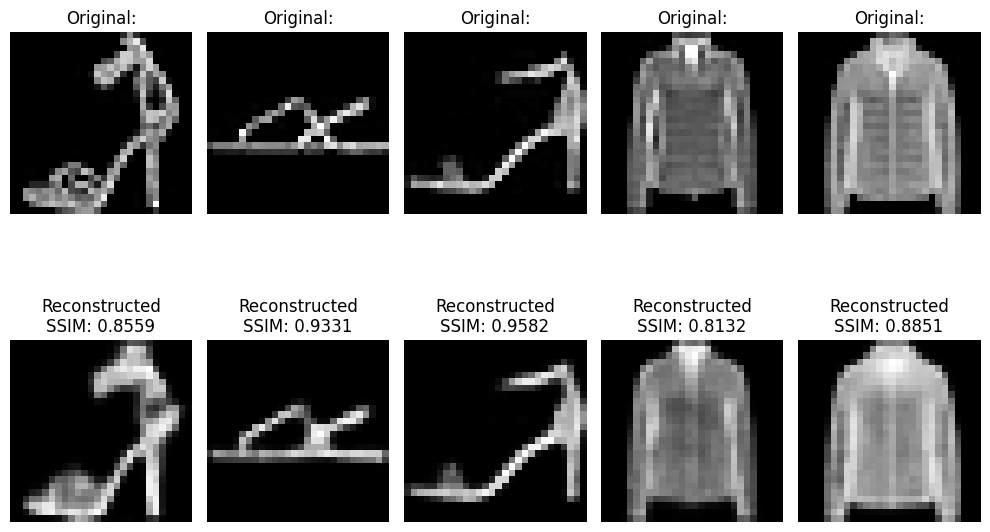

In [152]:
# Mengevaluasi model dengan SSIM
avg_ssim, original_images, reconstructed_images, ssim_scores = evaluate_ssim(baseline_autoencoder, x_train)

# Plot the first three original and reconstructed image pairs
plot_images(original_images, reconstructed_images, ssim_scores)

Modified Model

300/300 [==============================] - 2s 5ms/step
Average SSIM: 0.8732700400120788


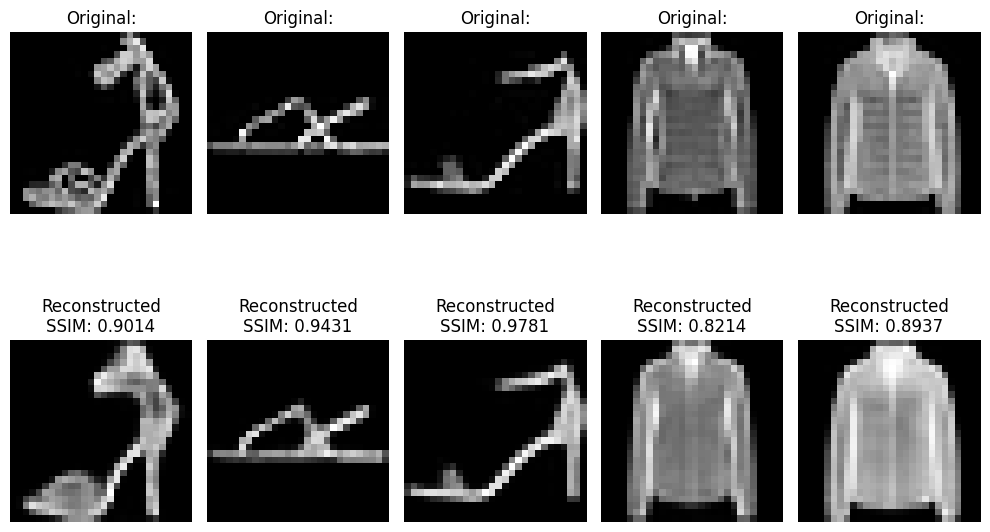

In [153]:
# Mengevaluasi model dengan SSIM
avg_ssim, original_images, reconstructed_images, ssim_scores = evaluate_ssim(modified_autoencoder, x_train)

# Plot the first three original and reconstructed image pairs
plot_images(original_images, reconstructed_images, ssim_scores)

Tuning Hyperparameter

300/300 [==============================] - 1s 3ms/step
Average SSIM: 0.850164239328266


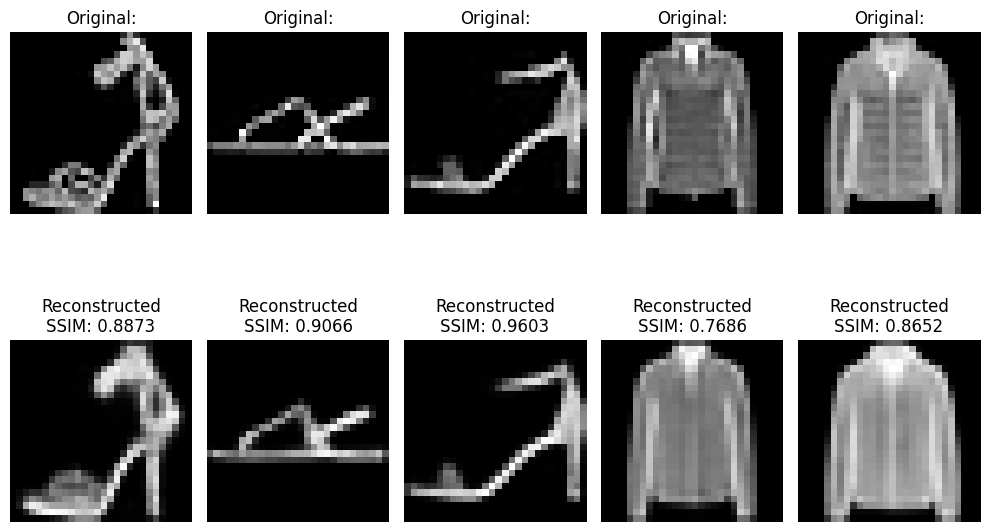

In [154]:
# Mengevaluasi model dengan SSIM
avg_ssim, original_images, reconstructed_images, ssim_scores = evaluate_ssim(best_model, x_train)

# Plot the first three original and reconstructed image pairs
plot_images(original_images, reconstructed_images, ssim_scores)